<div>
    <img src = "https://media.winefolly.com/Different-Types-of-Wine-v2.jpg" width="600">
</div>

# Predicting Wine Quality

Wine has a long and interesting history. It has been dated back as far as [6000 B.C.](https://en.wikipedia.org/wiki/History_of_wine), and has only continued to rise in popularity. There are so many wines available today, and it can definitely be daunting to try and enter the world of wine with no experience. How do you choose a wine? What makes a wine good? Are there different qualities of wine? This project will aim to predict whether the quality of a given wine is "good" or "bad" given its chemical properties such as its acidity levels, sulfur dioxide levels, pH, sulphates, alcohol, etc. We will employ the usage of several machine learning models to help us create a good model to accuractely predict wine quality.

# Import Libraries & Tools

In [1]:
#import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Data Exploration

For the sake of this project we will only closely examine the red wine dataset. When we clean, model, and predict, we will do so on both datasets.

In [2]:
#read in our data
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

In [3]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
#inspect datatypes
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


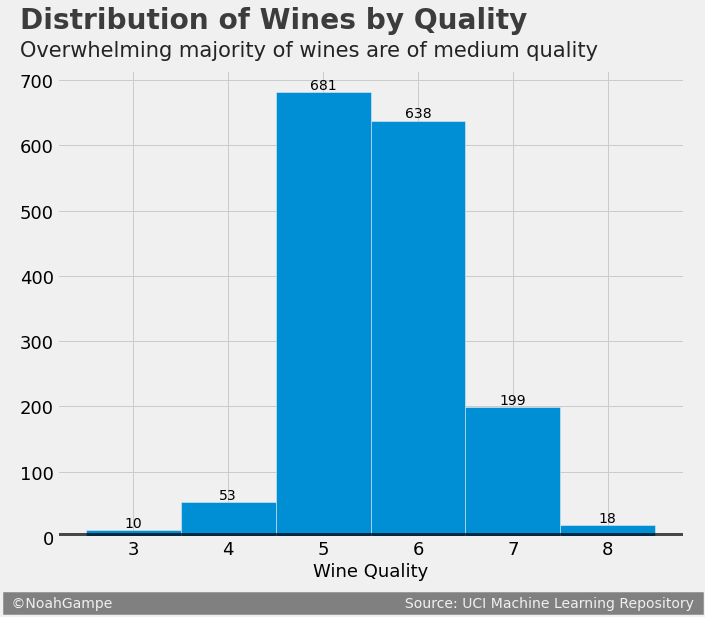

In [5]:
def plot_dist(df, col, title, sub):
    #figure details
    fig = plt.figure(figsize=(10,8))
            
    #plot
    ax = sns.histplot(data=df, x=col, bins=6, discrete=True, alpha=1, legend=False)
    for i in ax.containers:
        ax.bar_label(i,)
    
    #styling
    ax.axhline(y = 0, color = "black", linewidth = 8, alpha = .7)
    ax.set_xlabel('Wine Quality', fontsize=18)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(labelsize=18)
    
    #title & subtitle
    ax.text(-0.06,1.09, s=title, fontsize=28, weight="bold", alpha=.75, transform=ax.transAxes)
    ax.text(-0.06,1.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)
    
    #signature bar
    ax.text(x=-0.08, y=-0.15,
            s=" ©NoahGampe" + ' '*65 + "Source: UCI Machine Learning Repository ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=ax.transAxes)
    
    plt.show()
    
title = "Distribution of Wines by Quality"
sub = "Overwhelming majority of wines are of medium quality"
plot_dist(red_wine, 'quality', title, sub)

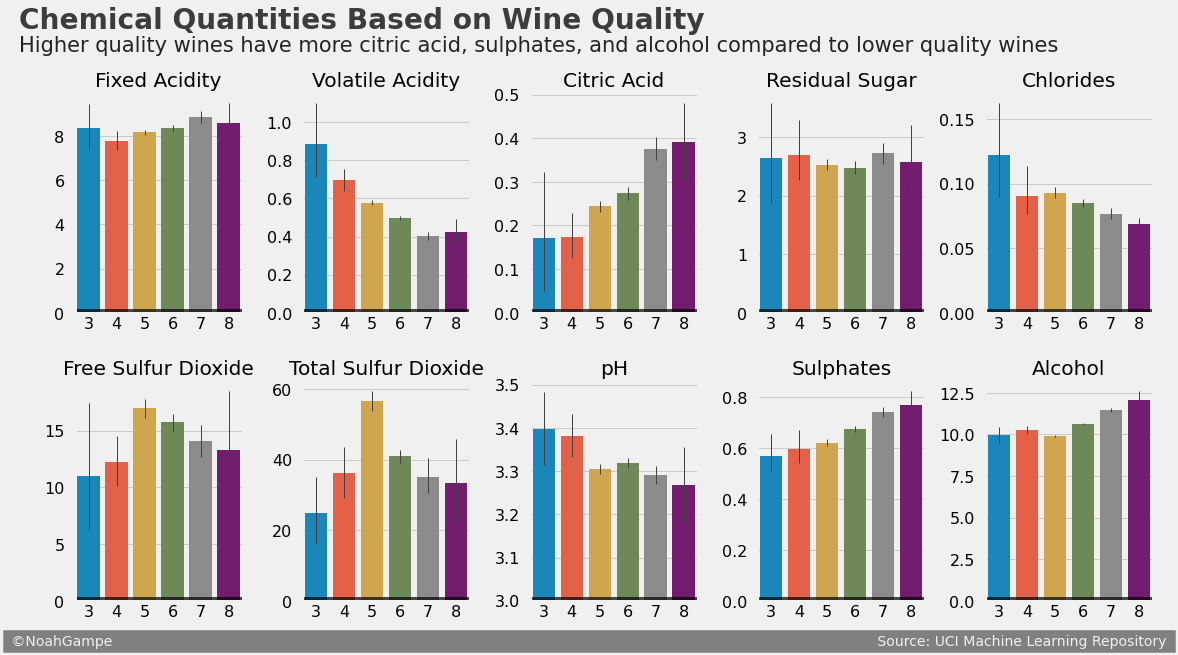

In [6]:
def plot_multi_dist(df, title, sub):
    #figure details
    fig = plt.figure(figsize=(16,8))
    
    #cols to plot
    cols = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides",
            "free sulfur dioxide", "total sulfur dioxide", "pH", "sulphates", "alcohol"]
    
    #titles for each plot
    titles = ["Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides",
              "Free Sulfur Dioxide", "Total Sulfur Dioxide", "pH", "Sulphates", "Alcohol"]
    
    #loop to plot
    for i, col in enumerate(cols):
        ax = fig.add_subplot(2,5,i+1)
            
        #plot
        ax = fig.tight_layout(pad = 1, h_pad=2)
        ax = sns.barplot(data=df, x=df["quality"], y=df[col], alpha=1, errwidth=1)
    
        #lines, labels, and limits
        ax.axhline(y=0, color='black', linewidth=8, alpha=.7)
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.tick_params(labelsize=16)
        ax.tick_params(axis='y', pad=10)
        
        if i == 7:
            ax.set_ylim(3,3.51)
            ax.axhline(y=3, color='black', linewidth=8, alpha=.7)
    
        #axes title
        ax.set_title(titles[i])
    
    #figure title & subtitle
    ax.text(-0.01,1.05, s=title, fontsize=28, weight='bold', alpha=.75, transform=fig.transFigure)
    ax.text(-0.01,1.01, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=-0.02, y=-0.02,
            s=' ©NoahGampe' + ' '*170 + 'Source: UCI Machine Learning Repository ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=fig.transFigure)
    
    plt.show()
    
title = "Chemical Quantities Based on Wine Quality"
sub = "Higher quality wines have more citric acid, sulphates, and alcohol compared to lower quality wines"
plot_multi_dist(red_wine, title, sub)

## Observations

* There are **11** characteristics of wine, and they are all represented by a float64 datatype
* Quality is represented by an int64 datatype
* There are no missing values
* Most of the wines have a quality of **5** & **6**
* Only **0.6%** have a quality of **3**, and **1.13%** have a quality of **8**
* Wines with a quality of **8** are higher in `citric acid`, `sulphates`, and `alcohol`, and lower in `volatile acidity`, `chlorides`, and `pH`

# What Makes Wine "Good"?

The quality and "goodness" of a wine can be heavily subjective. Everyone has different preferences and tastes, making the task to quantify a wine's quality difficult. However, several things can heavily affect the grapes used to make the wine, such as climate, weather, harvesting techniques, and winemaking practices.

> * Cooler climates produce wines higher in acidity but lower in sugar and alcohol. Hotter climates encourage ripening, leading to wines with higher sugars, higher alcohol and fuller body.
> * Canopy management often includes removing extra leaves and shoots to increase sunlight exposure, while pruning removes select branches to control yields and keep vines healthy. Harvesting is another crucial factor, since a harvest that is too early or late can lead to grapes lacking their ideal balance.
> * Wineries follow four main steps when producing their wines, maceration, fermentation, extraction and aging, and they must ensure consistency to get the most from their grapes. Inputs such as sulfur dioxide and processing enzymes, as well as [decisions with oak barrel aging and oxygen management](https://www.wineland.co.za/effect-of-viticultural-and-winemaking-practices-on-the-phenolic-composition-of-grapes-and-wines-part-ii/), all contribute to the quality of wine – from the exceptional to the insipid.
> The five components – acidity, tannins, sugar/sweetness, alcohol and fruit – need to be balanced. For wines that need several years of aging to reach maturity, this gives them the time they need to reach optimal balance.
>
> — [JJ Buckley Fine Wines](https://www.jjbuckley.com/wine-knowledge/blog/the-4-factors-and-4-indicators-of-wine-quality/1009), 2018

We can easily see in our data that we have several columns dealing with acidity, sugar, and alcohol. But how do any of these things affect the overall quality of the finished wine? To find out, we can make a correlation heatmap.

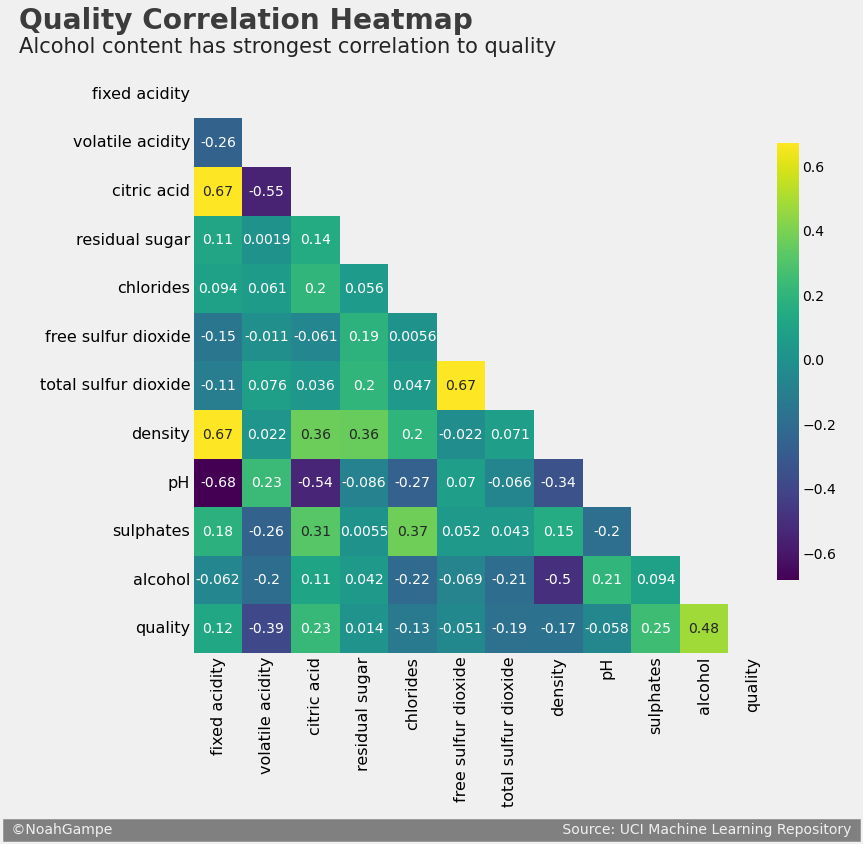

In [7]:
def plot_corr(df):
    data = df.corr()
    shrink = 0.75
    pad = 0
    fig_h = 10
    title = "Quality Correlation Heatmap"
    sub = "Alcohol content has strongest correlation to quality"
        
    if data.shape[0] == data.shape[1]:
        mask = np.zeros_like(data, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = False
        
    #figure details
    fig = plt.figure(figsize=(16,fig_h))
    fig.tight_layout()
    
    #plot details
    ax = sns.heatmap(data, square=True, mask=mask, cmap='viridis', annot=True, cbar_kws={'shrink': shrink, 'pad': pad})
              
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 16)

    #title & subtitle
    ax.text(-0.3,1.07, s=title, fontsize=28, weight="bold", alpha=.75, transform=ax.transAxes)
    ax.text(-0.3,1.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)
    
    #signature bar
    ax.text(x=-0.32, y=-0.31,
            s=" ©NoahGampe" + ' '*100 + "Source: UCI Machine Learning Repository ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=ax.transAxes)
    
    plt.show()
    
plot_corr(red_wine)

In [8]:
#get correlation values between 'quality' and other columns
red_corr = red_wine.corr()['quality'][:-1].abs().sort_values(ascending=False)
red_corr

alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

## Observations

* Looking at the correlation heatmap, we can clearly see that `alcohol` has the strongest positive correlation to quality
* Conversely, `volatile acidity` has the strongest negative correlation to quality
* Things like `residual sugar`, `free sulfur dioxide`, and `pH` don't have much of an effect on a wine's quality

# Preparing Data for Modeling



In [9]:
# #set up the fivethirtyeight style
# style.use('fivethirtyeight')
# fig, ax = plt.subplots(figsize=(9, 5))

# #change color of bars based on correlation value
# positive_white = white_corr >= 0
# positive_red = red_corr >= 0
# cmap_white = positive_white.map({True:'#33A1C9', False:'#ffae42'})
# cmap_red = positive_red.map({True:'#33A1C9', False:'#ffae42'})

# #type of plot we'll be using - in this case, horizontal bar graph
# ax.barh(white_corr.index, white_corr, left=2, height=0.5, color=cmap_white)
# ax.barh(red_corr.index, red_corr, left=-0.1, height=0.5, color=cmap_red)

# #removes grid and ticklabels
# ax.grid(None)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

# #create the tick marks in the middle, since they're common between both graphs
# x_coords = {'Alcohol': 0.82, 'Sulphates': 0.77, 'pH': 0.91,
#             'Density': 0.80, 'Total Sulfur Dioxide': 0.59,
#             'Free Sulfur Dioxide': 0.6, 'Chlorides': 0.77,
#             'Residual Sugar': 0.67, 'Citric Acid': 0.76,
#             'Volatile Acidity': 0.67, 'Fixed Acidity': 0.71}
# y_coord = 9.8

# for y_label, x_coord in x_coords.items():
#     ax.text(x_coord, y_coord, y_label)
#     y_coord -= 1
    
# #create two vertical grey lines, one on each side of the labels
# ax.axvline(0.5, color='grey', alpha=0.1, linewidth=1, ymin=0.1, ymax=0.9)
# ax.axvline(1.45, color='grey', alpha=0.1, linewidth=1, ymin=0.1, ymax=0.9)
    
# #create horizontal grey lines underneath each plot
# ax.axhline(-1, color='grey', linewidth=1, alpha=0.5, xmin=0.01, xmax=0.32)
# ax.axhline(-1, color='grey', linewidth=1, alpha=0.5, xmin=0.67, xmax=0.98)

# #add x-tick labels to each plot
# ax.text(-0.7, -1.7, '-0.5'+ ' '*31 + '+0.5', color='grey', alpha=0.5)
# ax.text(1.43, -1.7, '-0.5'+ ' '*31 + '+0.5', color='grey', alpha=0.5)

# #create horizontal line above each plot
# ax.axhline(11, color='grey', linewidth=1, alpha=0.5, xmin=0.01, xmax=0.32)
# ax.axhline(11, color='grey', linewidth=1, alpha=0.5, xmin=0.67, xmax=0.98)

# #add titles above each plot
# ax.text(-0.33, 11.2, 'RED WINE', weight='bold')
# ax.text(1.75, 11.2, 'WHITE WINE', weight='bold')

# #add a 'signature' bar at the bottom of our graph
# ax.text(-0.7, -2.9, '©DATAQUEST' + ' '*94 + 'Source: P. Cortez et al.',
#         color = '#f0f0f0', backgroundcolor = '#4d4d4d', size=12)

# #add title and subtile to maximize data-ink
# ax.text(-0.7, 13.5, 'Wine Quality Most Strongly Correlated With Alcohol Level', 
#         size=17, weight='bold')
# ax.text(-0.7, 12.7, 'Correlation values between wine quality and wine properties (alcohol, pH, etc.)'),

# #display the final graph
# plt.show()